In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/SGP/creditcard.csv')

In [ ]:
# Separate features (X) and labels (y)
X = data.iloc[:, :-1].values  # Features (all columns except the last)
y = data.iloc[:, -1].values   # Labels (the last column)

In [ ]:
# KNN Imputer replaces missing values with the mean of the nearest neighbors
knn_imputer = KNNImputer(n_neighbors=5)
X_imputed = knn_imputer.fit_transform(X)  # Impute missing values

In [ ]:
# StandardScaler standardizes features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [ ]:
# Using subset of the data to prevent crashes (tune the subset_size for your system's capacity)
subset_size = 10000  # Adjust based on available system memory
if X_scaled.shape[0] > subset_size:
    np.random.seed(42)  # For reproducibility
    sample_indices = np.random.choice(X_scaled.shape[0], subset_size, replace=False)
    X_sample = X_scaled[sample_indices]
    y_sample = y[sample_indices]
else:
    X_sample = X_scaled
    y_sample = y

In [ ]:
# Step 1: Determine optimal eps using K-distance Graph
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_sample)
distances, indices = neighbors_fit.kneighbors(X_sample)
distances = np.sort(distances[:, -1], axis=0)  # Sort based on the largest distance in each row

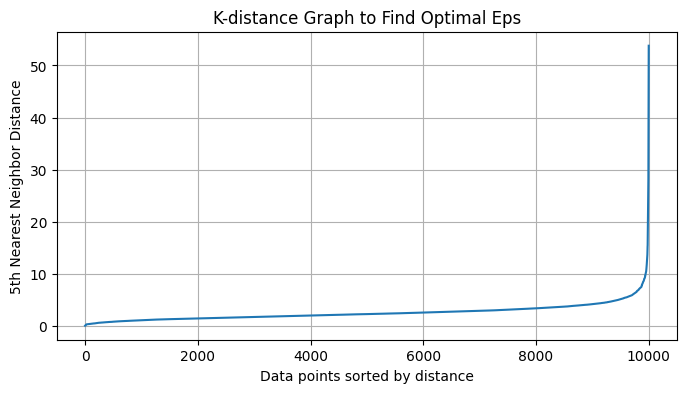

In [ ]:
# Plot the K-distance graph
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title('K-distance Graph to Find Optimal Eps')
plt.xlabel('Data points sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.grid(True)
plt.show()

In [ ]:
# Calculate the elbow point as optimal eps
differences = np.diff(distances)
elbow_index = np.argmax(differences)
elbow_eps = distances[elbow_index]
print(f'Elbow point (optimal eps): {elbow_eps:.3f}')

Elbow point (optimal eps): 38.567


In [ ]:
# Step 2: Apply DBSCAN with tuned parameters
eps_value = elbow_eps
min_samples_value = 5  # Lowering min_samples to detect smaller clusters
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
dbscan.fit(X_sample)

DBSCAN(eps=38.56710133253146)

In [ ]:
# Try a smaller eps value for better separation
eps_value = elbow_eps * 0.5  # Reduce the eps value to form distinct clusters
min_samples_value = 10  # Increase min_samples to improve cluster separation
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
dbscan.fit(X_sample)

DBSCAN(eps=19.28355066626573, min_samples=10)

In [ ]:
# Get the cluster labels (-1 represents noise)
cluster_labels = dbscan.labels_

In [ ]:
# Step 3: Evaluation Metrics
if len(set(cluster_labels)) > 1:  # Silhouette score is not defined for a single cluster
    silhouette_avg = silhouette_score(X_sample, cluster_labels)
    print(f'Silhouette Score: {silhouette_avg:.3f}')
else:
    print('Silhouette Score: Not defined for a single cluster')

ari_score = adjusted_rand_score(y_sample, cluster_labels)
print(f'Adjusted Rand Index (ARI): {ari_score:.3f}')

if len(set(cluster_labels)) > 1:
    db_score = davies_bouldin_score(X_sample, cluster_labels)
    print(f'Davies-Bouldin Index: {db_score:.3f}')
else:
    print('Davies-Bouldin Index: Not defined for a single cluster')

Silhouette Score: 0.855
Adjusted Rand Index (ARI): 0.141
Davies-Bouldin Index: 2.284


In [ ]:
# Step 4: Visualize the results using PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
X_pca = pca.fit_transform(X_sample)

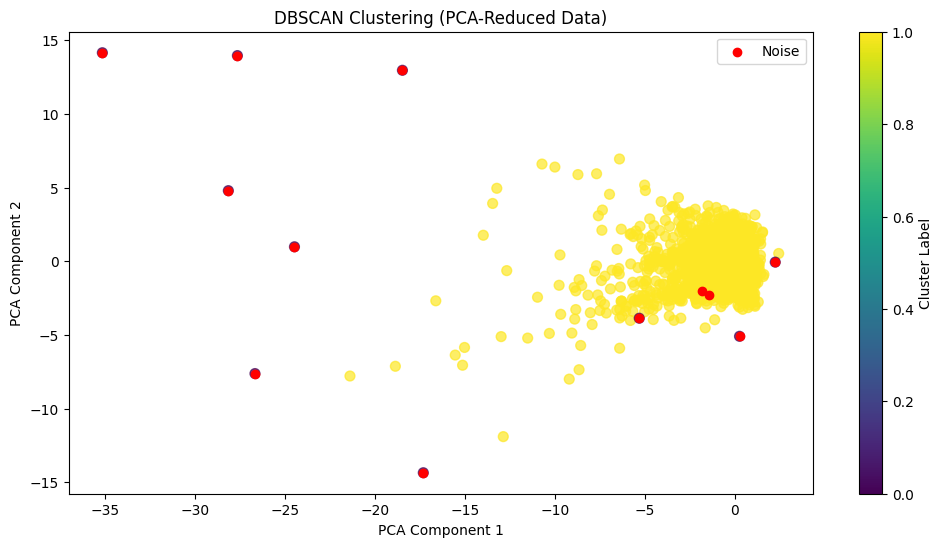

In [ ]:
# Scatter plot of the clusters
plt.figure(figsize=(12, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.7)
plt.scatter(X_pca[cluster_labels == -1, 0], X_pca[cluster_labels == -1, 1], color='red', label='Noise')
plt.title('DBSCAN Clustering (PCA-Reduced Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.legend()
plt.show()

In [ ]:
# Step 5: Count the number of noise points (labeled as -1)
n_noise = np.sum(cluster_labels == -1)
print(f'Number of noise points: {n_noise}')

Number of noise points: 12
